In [ ]:
#Student Name: Liguangxuan He
#Student ID: 1006141809
#Instructor Name: Prof. Shion Guha
#Course Code: INF2178
#Course Name: Experimental Design for Data Science
#Program: Master of Information
#Faculty: Faculty of Information
#School: University of Toronto

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro
from scipy.stats import levene
from statsmodels.sandbox.predict_functional import predict_functional

In [ ]:
#read csv from drive
file_path = '/content/drive/MyDrive/Inf2178 Assignment/Technical 3/INF2178_A3_data.csv'
df = pd.read_csv(file_path)
#display the first 6 rows
df.head(6)

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
0,36.58,39.54,33.822,49.37,50.10,40.533,140000.0,140.0,3
1,50.82,44.44,38.147,83.50,58.93,37.409,120000.0,120.0,3
2,40.68,28.57,28.108,40.41,32.81,29.312,90000.0,90.0,3
3,32.57,23.57,15.404,34.14,35.25,27.382,50000.0,50.0,2
4,31.98,19.65,18.727,32.84,23.60,26.977,55000.0,55.0,2
5,50.45,36.27,33.352,64.13,53.31,32.703,150000.0,150.0,3


In [ ]:
#check basic information about the data such as column names, data types, non-null counts.
print(df.info())
#after reading the basic information about the data is this csv, nothing needs to be clean.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fallreadingscore             11933 non-null  float64
 1   fallmathscore                11933 non-null  float64
 2   fallgeneralknowledgescore    11933 non-null  float64
 3   springreadingscore           11933 non-null  float64
 4   springmathscore              11933 non-null  float64
 5   springgeneralknowledgescore  11933 non-null  float64
 6   totalhouseholdincome         11933 non-null  float64
 7   incomeinthousands            11933 non-null  float64
 8   incomegroup                  11933 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 839.2 KB
None


In [ ]:
#get info about descriptive states for numerical columns
round(df.describe(),2)

,fallreadingscore,fallmathscore,fallgeneralknowledgescore,springreadingscore,springmathscore,springgeneralknowledgescore,totalhouseholdincome,incomeinthousands,incomegroup
count,11933.00,11933.00,11933.00,11933.00,11933.00,11933.00,11933.00,11933.00,11933.00
mean,35.95,27.13,23.07,47.51,37.80,28.24,54317.20,54.32,1.90
std,10.47,9.12,7.40,14.33,12.03,7.58,36639.06,36.64,0.82
min,21.01,10.51,6.98,22.35,11.90,7.86,1.00,0.00,1.00
25%,29.34,20.68,17.39,38.95,29.27,22.80,27000.00,27.00,1.00
50%,34.06,25.68,22.95,45.32,36.41,28.58,47000.00,47.00,2.00
75%,39.89,31.59,28.30,51.77,44.22,33.78,72000.00,72.00,3.00
max,138.51,115.65,47.69,156.85,113.80,48.34,150000.00,150.00,3.00


**Explanatory data analysis (EDA)**  
1. How do students' scores improve from fall to spring?  
2. Is there a relationship between household income and students' scores?  
3. Does the income group affect the scores' improvement from fall to spring?  

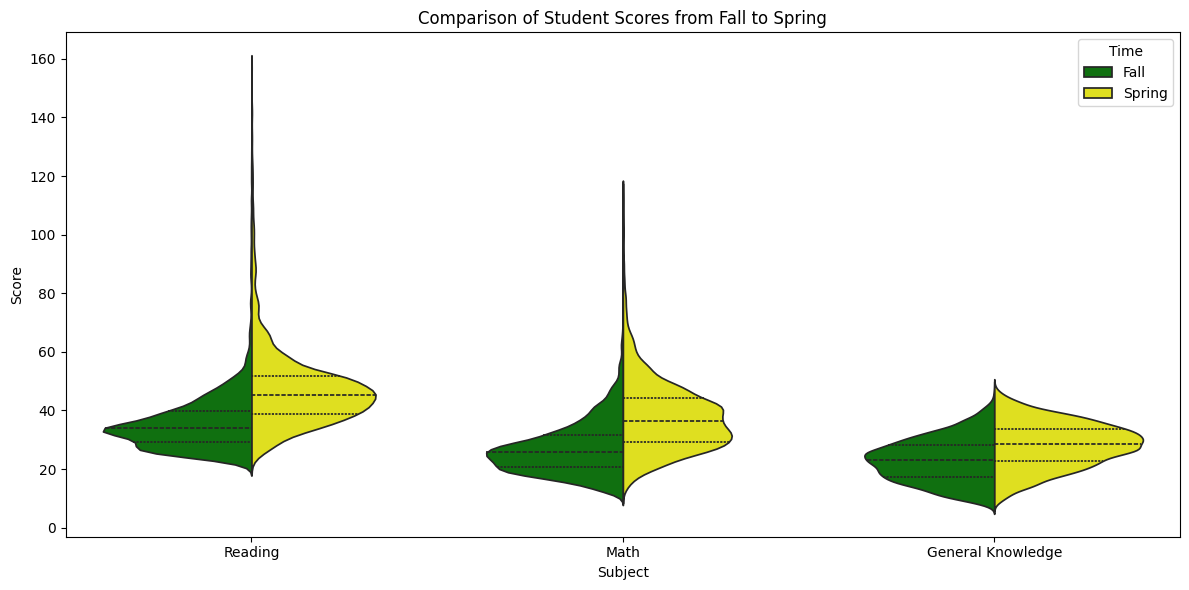

In [ ]:
#1.How does students' scores improve from fall to spring?
#prepare the data for fall and spring scores
fall_scores = df[['fallreadingscore', 'fallmathscore', 'fallgeneralknowledgescore']].melt(value_name='Score', var_name='Subject')
fall_scores['Time'] = 'Fall'

spring_scores = df[['springreadingscore', 'springmathscore', 'springgeneralknowledgescore']].melt(value_name='Score', var_name='Subject')
spring_scores['Time'] = 'Spring'

#combine fall and spring data
all_scores = pd.concat([fall_scores, spring_scores])

#map the 'Subject' column to more readable names
subject_map = {
    'fallreadingscore': 'Reading',
    'fallmathscore': 'Math',
    'fallgeneralknowledgescore': 'General Knowledge',
    'springreadingscore': 'Reading',
    'springmathscore': 'Math',
    'springgeneralknowledgescore': 'General Knowledge'
}
all_scores['Subject'] = all_scores['Subject'].map(subject_map)

#display the plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Subject', y='Score', hue='Time', data=all_scores, split=True, inner="quart", palette=['green', 'yellow'])
plt.title('Comparison of Student Scores from Fall to Spring')
plt.xlabel('Subject')
plt.ylabel('Score')
plt.legend(title='Time')
plt.tight_layout()
plt.show()

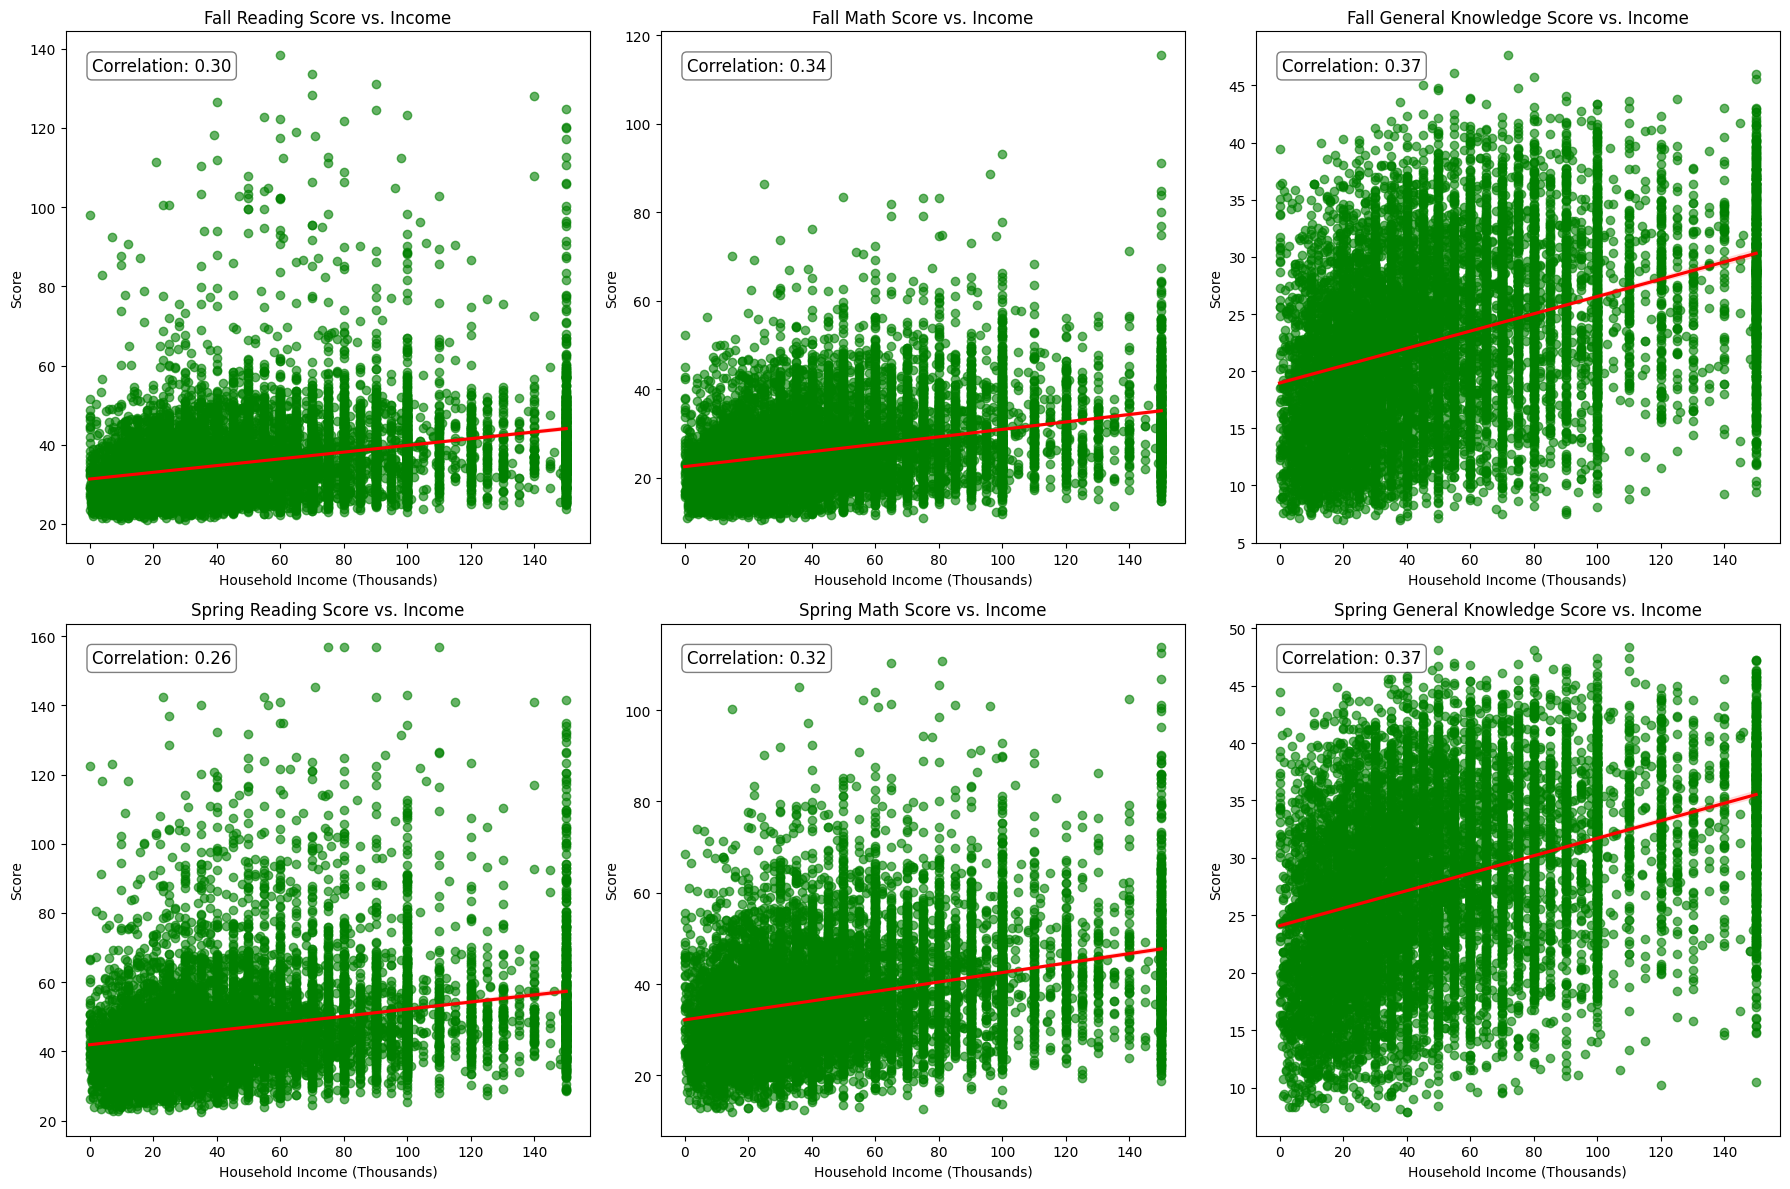

In [ ]:
#2.Is there a relationship between household income and students' scores?
#set up the matplotlib figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

#titles and variables for plotting
titles = ['Fall Reading Score vs. Income', 'Fall Math Score vs. Income', 'Fall General Knowledge Score vs. Income',
          'Spring Reading Score vs. Income', 'Spring Math Score vs. Income', 'Spring General Knowledge Score vs. Income']
score_variables = ['fallreadingscore', 'fallmathscore', 'fallgeneralknowledgescore',
                   'springreadingscore', 'springmathscore', 'springgeneralknowledgescore']

#plotting each relationship
for i, score_var in enumerate(score_variables):
    sns.regplot(ax=axes[i], x='incomeinthousands', y=score_var, data=df, scatter_kws={'alpha':0.6}, line_kws={'color': 'red'}, color='green')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Household Income (Thousands)')
    axes[i].set_ylabel('Score')

    #calculate the correlation coefficient
    cor = df['incomeinthousands'].corr(df[score_var])
    #annotate the plot with the correlation coefficient
    axes[i].text(0.05, 0.95, f'Correlation: {cor:.2f}', transform=axes[i].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

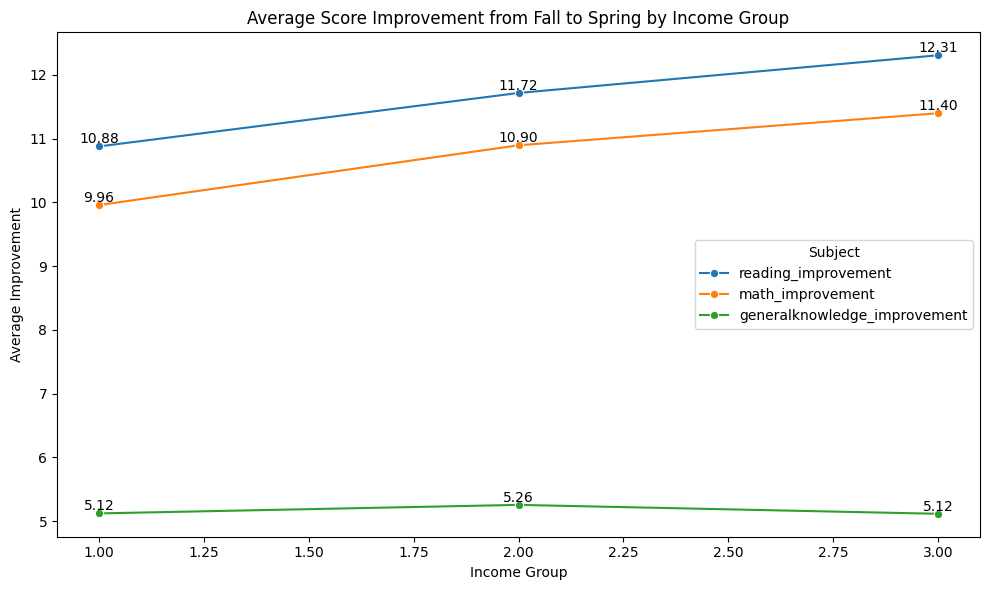

In [ ]:
#3.does the income group affect the scores' improvement from fall to spring?
#calculate the score improvements
df['reading_improvement'] = df['springreadingscore'] - df['fallreadingscore']
df['math_improvement'] = df['springmathscore'] - df['fallmathscore']
df['generalknowledge_improvement'] = df['springgeneralknowledgescore'] - df['fallgeneralknowledgescore']

#group by income group and calculate the mean improvement
mean_improvements_by_income = df.groupby('incomegroup')[['reading_improvement', 'math_improvement', 'generalknowledge_improvement']].mean().reset_index()

#melt for plotting
melted_improvements = mean_improvements_by_income.melt(id_vars='incomegroup', var_name='Subject', value_name='Average Improvement')

#plot line graph
plt.figure(figsize=(10, 6))
sns.lineplot(x='incomegroup', y='Average Improvement', hue='Subject', data=melted_improvements, marker='o')
plt.title('Average Score Improvement from Fall to Spring by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Average Improvement')
plt.legend(title='Subject')
#label each point with its value
for index, row in melted_improvements.iterrows():
    plt.text(row['incomegroup'], row['Average Improvement'], f'{row["Average Improvement"]:.2f}', color='black', ha="center", va="bottom")
plt.tight_layout()
plt.show()

**One-way ANCOVA using statsmodels:**    
How do the reading and math scores of students change from fall to spring, and how is this change influenced by the students' income group, after controlling for their baseline general knowledge scores?  
  
Hypotheses:  


1. **Main Effect of Time on Academic Scores:** reading and math scores will significantly change from fall to spring.
2.  **Main Effect of Income Group on Academic Score Changes:**The change in students' reading and math scores from fall to spring will vary across different income groups.
3. **Interaction Effect:** The effect of time on academic scores (reading and math) will be moderated by the income group of the students, even after controlloing for their baseline general knowledge scores.  





<ipython-input-10-63094691f7d7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='incomegroup', y='reading_improvement', data=df, palette='Greens')
<ipython-input-10-63094691f7d7>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='incomegroup', y='math_improvement', data=df, palette='Greens')


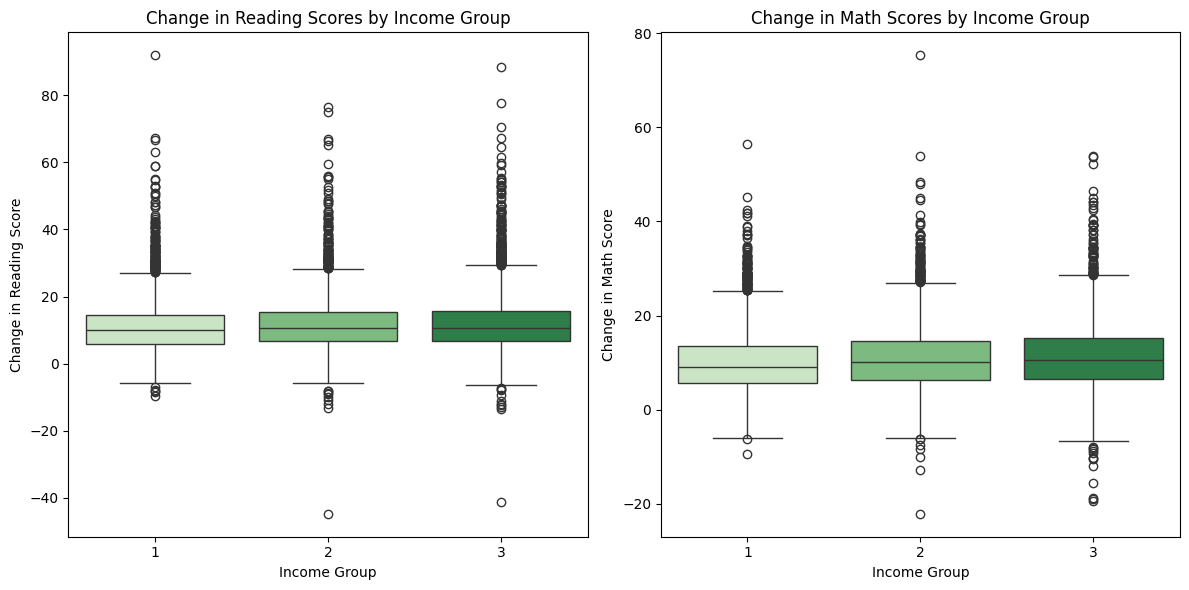

In [ ]:
#before going into ANCOVA analysis, use boxplot create visual representation of variability of score changes across different socio-economic status.
#help identify trends or outliers
#set up the matplotlib figure
plt.figure(figsize=(12, 6))

#create subplot 1: boxplot for change in reading scores by income group
plt.subplot(1, 2, 1)
sns.boxplot(x='incomegroup', y='reading_improvement', data=df, palette='Greens')
plt.title('Change in Reading Scores by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Change in Reading Score')

#create subplot 2: boxplot for change in math scores by income group
plt.subplot(1, 2, 2)
sns.boxplot(x='incomegroup', y='math_improvement', data=df, palette='Greens')
plt.title('Change in Math Scores by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Change in Math Score')
plt.tight_layout()
plt.show()

In [ ]:
#one-way ANCOVA model 1: change in reading score as a function of income group, controlling for fall general knowledge score
ancova_model = ols('reading_improvement ~ C(incomegroup) + fallgeneralknowledgescore', data=df).fit()

#print the ANCOVA table
print(ancova_model.summary())

                             OLS Regression Results                            
Dep. Variable:     reading_improvement   R-squared:                       0.023
Model:                             OLS   Adj. R-squared:                  0.023
Method:                  Least Squares   F-statistic:                     95.49
Date:                 Sat, 23 Mar 2024   Prob (F-statistic):           4.52e-61
Time:                         04:35:37   Log-Likelihood:                -41730.
No. Observations:                11933   AIC:                         8.347e+04
Df Residuals:                    11929   BIC:                         8.350e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept   

In [ ]:
#one-way ANCOVA model 1:
#post hoc test using Tukey's hsd test for pariwise comparison among income groups
tukey_results = pairwise_tukeyhsd(endog=df['reading_improvement'], groups=df['incomegroup'], alpha=0.05)
#print the tukey's result
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2   0.8387    0.0 0.4246 1.2527   True
     1      3   1.4301    0.0 1.0079 1.8523   True
     2      3   0.5915 0.0053 0.1458 1.0371   True
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk test p-value: 0.00


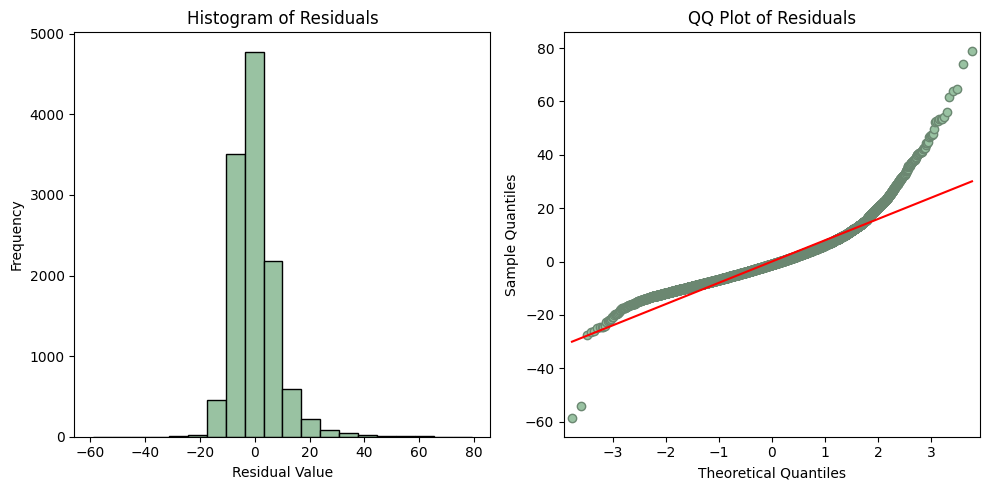

In [ ]:
#one-way ANCOVA model 1: Assumption Check
#assumption 1: Normality of residual
residuals = ancova_model.resid

#Shapiro-Wilk test
stat, p_value = shapiro(residuals)
print(f'Shapiro-Wilk test p-value: {p_value:.2f}')

#histogram of residuals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, edgecolor='black', color = '#99c2a2')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

#QQ plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca(), markerfacecolor='#99c2a2', markeredgecolor='#6b8771')
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.tight_layout()
plt.show()

In [ ]:
#one-way ANCOVA model 1: Assumption Check
#assumption 2: homogeneity of variances
#Levene's test(for not normally distributed samples)
#add residuals to the dataframe for future use
df['residuals'] = ancova_model.resid

#group residuals by 'incomegroup'
grouped_residuals = [df[df['incomegroup'] == group]['residuals'] for group in sorted(df['incomegroup'].unique())]

#perform Levene's test for homogeneity of variances
levene_stat, levene_p = levene(*grouped_residuals)

#number of groups and total sample size
k = len(grouped_residuals)  #number of groups
N = sum([len(group) for group in grouped_residuals])  #total sample size

#calculate degrees of freedom
df1 = k - 1 #degrees of freedom between groups
df2 = N - k #degrees of freedom within groups

#create dataframe to display the summary table
summary_df = pd.DataFrame({
    'Test Statistics':[levene_stat],
    'df1 (Between Groups)':[df1],
    'df2 (Within Groups)':[df2],
    'p-value':[levene_p]
})

#display the summary table
round(summary_df,4)

,Test Statistics,df1 (Between Groups),df2 (Within Groups),p-value
0,26.9558,2,11930,0.0


In [ ]:
#one-way ANCOVA model 2: change in math score as a function of income group, controlling for fall general knowledge score
ancova_model2 = ols('math_improvement ~ C(incomegroup) + fallgeneralknowledgescore', data=df).fit()

#print the ANCOVA table
print(ancova_model2.summary())

                            OLS Regression Results                            
Dep. Variable:       math_improvement   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     200.0
Date:                Fri, 22 Mar 2024   Prob (F-statistic):          1.36e-126
Time:                        20:12:10   Log-Likelihood:                -39610.
No. Observations:               11933   AIC:                         7.923e+04
Df Residuals:                   11929   BIC:                         7.926e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [ ]:
#one-way ANCOVA model 2:
#post hoc test using Tukey's hsd test for pariwise comparison among income groups
tukey_results2 = pairwise_tukeyhsd(endog=df['math_improvement'], groups=df['incomegroup'], alpha=0.05)
#print the tukey's result
print(tukey_results2)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2   0.9377    0.0 0.5871 1.2883   True
     1      3   1.4406    0.0 1.0831 1.7982   True
     2      3    0.503 0.0051 0.1256 0.8803   True
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk test p-value for model 2: 0.00


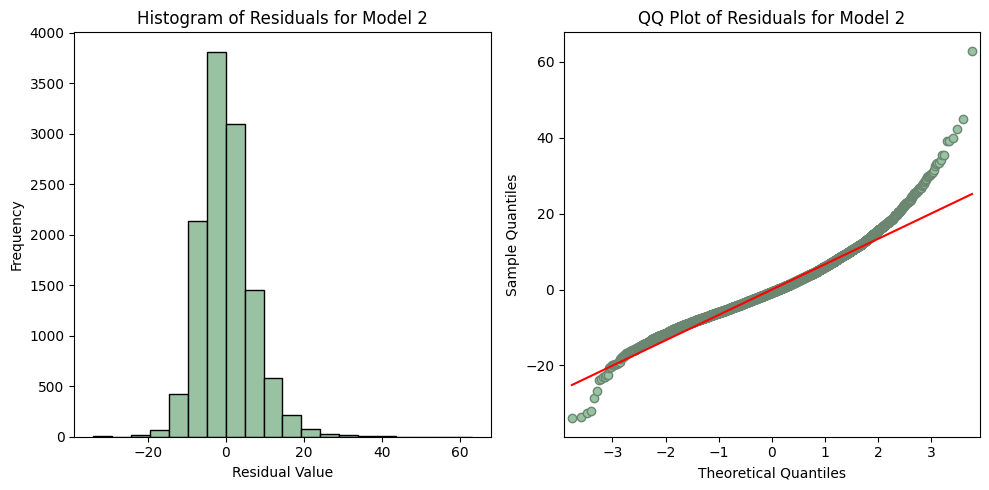

In [ ]:
#one-way ANCOVA model 2: Assumption Check
#assumption 1: Normality of residual
#extract the residuals from the second model
residuals2 = ancova_model2.resid

#perform the Shapiro-Wilk test on these residuals
stat2, p_value2 = shapiro(residuals2)
print(f'Shapiro-Wilk test p-value for model 2: {p_value2:.2f}')

#plotting the histogram of residuals for the second model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(residuals2, bins=20, edgecolor='black', color='#99c2a2')
plt.title('Histogram of Residuals for Model 2')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

#generating a QQ plot for the residuals of the second model
plt.subplot(1, 2, 2)
sm.qqplot(residuals2, line='s', ax=plt.gca(), markerfacecolor='#99c2a2', markeredgecolor='#6b8771')
plt.title('QQ Plot of Residuals for Model 2')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.tight_layout()
plt.show()

In [ ]:
#one-way ANCOVA model 2: Assumption Check
#assumption 2: homogeneity of variances
#Levene's test(for not normally distributed samples)
#add residuals to the dataframe for future use
df['residuals2'] = ancova_model2.resid

#group residuals by 'incomegroup'
grouped_residuals2 = [df[df['incomegroup'] == group]['residuals2'] for group in sorted(df['incomegroup'].unique())]

#perform Levene's test for homogeneity of variances
levene_stat2, levene_p2 = levene(*grouped_residuals2)

#number of groups and total sample size
k = len(grouped_residuals2)  #number of groups
N = sum([len(group) for group in grouped_residuals2])  #total sample size

#calculate degrees of freedom
df1 = k - 1 #degrees of freedom between groups
df2 = N - k #degrees of freedom within groups

#create dataframe to display the summary table
summary_df2 = pd.DataFrame({
    'Test Statistics':[levene_stat2],
    'df1 (Between Groups)':[df1],
    'df2 (Within Groups)':[df2],
    'p-value':[levene_p]
})

#display the summary table
round(summary_df2,4)

,Test Statistics,df1 (Between Groups),df2 (Within Groups),p-value
0,30.2223,2,11930,0.0
